# Global Sea Ice Extent Graph

This code will download and render a current graph of the global sea ice extent. Beginning in 1979 until yesterday (based on availability of the raw data from the NSIDC).

### Location of the requisite data files (in case you need to manually download them):

[ftp://sidads.colorado.edu:21/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v2.1.csv](ftp://sidads.colorado.edu:21/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v2.1.csv)

[ftp://sidads.colorado.edu:21/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v2.1.csv](ftp://sidads.colorado.edu:21/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v2.1.csv)


In [45]:
# Load all needed libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import os
import math
import calendar
import urllib
import shutil

# Set up some constants
LOCAL_DATA_PATH = './data'
LOCAL_OUTPUT_PATH = './output'
DATA_URLS = {
    's': 'ftp://sidads.colorado.edu:21/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v2.1.csv',
    'n': 'ftp://sidads.colorado.edu:21/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v2.1.csv'
}

pd.set_option('display.max_rows', 5)


In [46]:
# Check if necessary directories exist
def mkdir_if_necessary(dir):
    try:
        os.stat(dir)
    except:
        os.mkdir(dir)       

# Check if our data files exist already
def data_files_exist():
    for key, url in DATA_URLS.items():
        filename = os.path.split(urllib.parse.urlsplit(url).path)[-1]
        if os.path.isfile(os.path.join(LOCAL_DATA_PATH, filename)):
            return True
        else:
            return False

# Load the data from disk and return the dataframes
def load_data_files():
    sea_ice_indexes = {}
    for key, url in DATA_URLS.items():
        filename = os.path.split(urllib.parse.urlsplit(url).path)[-1]
        sea_ice_indexes[key] = pd.read_csv(os.path.join(LOCAL_DATA_PATH, filename), skiprows=[1])
    for key in sea_ice_indexes.keys():
        sea_ice_indexes[key].rename(columns=lambda x: x.strip(), inplace=True)
        sea_ice_indexes[key]['Date'] = sea_ice_indexes[key].apply(lambda row: datetime.date(
                                       row['Year'], row['Month'], row['Day']), axis=1)
        sea_ice_indexes[key]['Day of Year'] = sea_ice_indexes[key].apply(lambda row: row['Date'].timetuple().tm_yday, axis=1)
        sea_ice_indexes[key]['Date'] = pd.to_datetime(sea_ice_indexes[key]['Date'])
    sea_ice_indexes['n'] = sea_ice_indexes['n'][['Extent', 'Date']]
    sea_ice_indexes['s'].rename(columns={'Extent': 'S Extent'}, inplace=True)
    sea_ice_indexes['n'].rename(columns={'Extent': 'N Extent'}, inplace=True)
    return sea_ice_indexes
        
# Check if our data appears to be out of date
def data_is_fresh(sea_ice_indexes):
    for key, sea_ice_index in sea_ice_indexes.items():
        today = datetime.date.today()
        print('Data is {0} day(s) old'.format((datetime.datetime.now() - sea_ice_index['Date'].iloc[-1]).days))
        if (datetime.datetime.now() - sea_ice_index['Date'].iloc[-1]).days >= 2:
            return False
        else:
            return True

# Update to latest data files
def refresh_data_files():
    for key, url in DATA_URLS.items():
        filename = os.path.join(LOCAL_DATA_PATH, os.path.split(urllib.parse.urlsplit(url).path)[-1])
        with urllib.request.urlopen(url) as response, open(filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)

# Prepare and load the data files downloading and updating as necessary
def prep_data_files():
    mkdir_if_necessary(LOCAL_DATA_PATH)
    mkdir_if_necessary(LOCAL_OUTPUT_PATH)

    if data_files_exist():
        print('Data files exist')
        sea_ice_indexes = load_data_files()
        if data_is_fresh(sea_ice_indexes):
            print('Data files are up to date')
        else:
            print('Data files are outdated')
            refresh_data_files()
            sea_ice_indexes = load_data_files()
            print('Data files have been updated')
    else:
        print('No data files found')
        refresh_data_files()
        sea_ice_indexes = load_data_files()
        print('Data files have been downloaded')
    return sea_ice_indexes


In [47]:
# Prepare and load the data files downloading and updating as necessary
sea_ice_indexes = prep_data_files()


Data files exist
Data is 1 day(s) old
Data files are up to date


In [48]:
global_sea_ice_index = pd.merge(left=sea_ice_indexes['s'],
                                right=sea_ice_indexes['n'],
                                on='Date')

global_sea_ice_index['Total Extent'] = global_sea_ice_index['S Extent'] + global_sea_ice_index['N Extent']

global_sea_ice_index


,Year,Month,Day,S Extent,Missing,Source Data,Date,Day of Year,N Extent,Total Extent
0,1978,10,26,17.624,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,1978-10-26,299,10.231,27.855
1,1978,10,28,17.803,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,1978-10-28,301,10.420,28.223
...,...,...,...,...,...,...,...,...,...,...
12326,2017,1,31,2.488,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsidc...,2017-01-31,31,13.774,16.262
12327,2017,2,1,2.475,0.0,['ftp://sidads.colorado.edu/pub/DATASETS/nsidc...,2017-02-01,32,13.821,16.296


In [49]:
global_sea_ice_index.index = global_sea_ice_index['Day of Year']
global_sea_ice_index.drop(['Missing','Source Data','Day','Date','Month','N Extent','Total Extent'], axis=1, inplace=True)
global_sea_ice_index.index = global_sea_ice_index.index.astype(datetime.datetime)

global_sea_ice_index


,Year,S Extent,Day of Year
Day of Year,,,
299,1978,17.624,299
301,1978,17.803,301
...,...,...,...
31,2017,2.488,31
32,2017,2.475,32


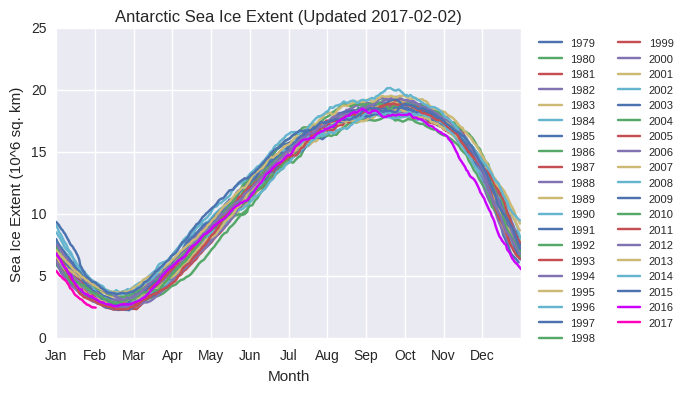

In [50]:
for key, grp in global_sea_ice_index.groupby(['Year']):
    if (key >= 1979 and key <= 2018) or key >= 2016:
        if key == 2017:
            plt.plot(grp['S Extent'], label=key, color="#ff00bb")
        elif key == 2016:
            plt.plot(grp['S Extent'], label=key, color="#cc00ff")
        else:
            plt.plot(grp['S Extent'], label=key)

plt.title('Antarctic Sea Ice Extent (Updated {0})'.format(datetime.date.today().isoformat()))
plt.xlabel("Month")
plt.xlim(1,366)
plt.xticks(np.linspace(1,366,13), calendar.month_abbr[1:13], rotation=0)
plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.35, 1), ncol=2, fontsize=8)
plt.ylabel("Sea Ice Extent (10^6 sq. km)")

plt.savefig('output/antarctic_sea_ice_{0}.png'.format(datetime.date.today().isoformat()),
        dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None)
